# Comparing cloud cover statistics for two sites - Flisa in Norway and Horn in Sweden

The goal of this analysis is to compare how much of the skies are clear around noon at the two sites in question. 
The sites of interest are Norwegian Flisa and Swedish Horn. We are trying to find out which of these locations is more likely to have clear(er) skies and which time of the year would be ideal in this regard. 

The location of the two towns can be seen in the following image.

![Map of Sweden and Norway showing the locations of Flisa and Horn.](map_flisa_horn.png "Figure 1: Map of southern parts of Sweden and Norway, showing locations of Flisa and Horn.") 

## Cloud coverage measurements

The Norwegian weather statistics can be found on [Norsk Klimaservicesenter](https://seklima.met.no/). 

The Swedish weather statistics are provided by [SMHI](https://www.smhi.se/data/meteorologi/ladda-ner-meteorologiska-observationer#param=totalCloudCover,stations=core). 

Cloud coverage is typically given in oktas. Oktas express how many eights of the sky are covered by clouds. 0 oktas means no clouds, 1 okta 1/8 of the sky or less, 8 oktas full cloud cover with no breaks. The oktas can be converted into the percentage of the sky covered by clouds.

The Swedish measurements include cloud coverage for every hour during the day, while the Norwegian data are only given at 3 time points for a given day -- 07:00, 13:00 and 19:00.

## Analysing the data
Since data for Flisa has a coarser time sampling, I will only focus on the 3 time points per day. I considered using the full data for Horn, but decided against it, in order to provide as fair of a comparison as possible. Although I return to the full data for Horn at the end, to provide a better estimate of the chances of clear skies. 

I limit my analysis to years 2017-2022. 

## Preparing the datasets

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data from Flisa

In [2]:

# Loading data from Flisa
data_flisa= pd.read_excel('flisaII_cloud_coverage_2017-2022.xlsx')
#print(data_flisa.head())
#print(data_flisa.index)

# Checking that the cloud coverage is a number, not string
print('Skydekke data type: ',data_flisa['Skydekke'].dtype)

# Separating date-time stamp into Day, Month, Year and Time
data_flisa[["Date", "Time"]] = data_flisa["Tid(norsk normaltid)"].str.split(expand=True)
data_flisa[["Day", "Month", "Year"]] = data_flisa.Date.str.split(".", expand=True)

# Removing unnecessary columns
data_flisa.drop(columns=["Tid(norsk normaltid)", "Stasjon", "Navn", "Date"], inplace=True)

# Renaming Skydekke to Cloud_cover
data_flisa.rename(columns={'Skydekke': 'Cloud_cover'}, inplace=True)

# Expressing Cloud_cover as a percentage, rather than in oktas
data_flisa["Cloud_cover"] = data_flisa["Cloud_cover"]/8*100

# Adding a column for location
data_flisa['Location']='Flisa'

print(data_flisa.head())


Skydekke data type:  float64
   Cloud_cover   Time Day Month  Year Location
0          0.0  07:00  01    01  2017    Flisa
1         12.5  13:00  01    01  2017    Flisa
2          0.0  19:00  01    01  2017    Flisa
3          0.0  07:00  02    01  2017    Flisa
4         25.0  13:00  02    01  2017    Flisa


### Data from Horn

In [3]:
# Loading data for Horn
data_horn = pd.read_csv('horn_cloud_coverage.csv')
#print(data_horn.head())
#print(data_horn.index)

# Separating the data into columns
data_horn.columns = ["Raw"]
data_horn[["Date", "Time", "Cloud_cover", "Other"]]=data_horn.Raw.str.split(";", expand=True)
data_horn[["Year", "Month", "Day"]]=data_horn.Date.str.split("-", expand=True)

# Removing the seconds from the time data to match it with Flisa
data_horn["Time"] = data_horn["Time"].map(lambda x: x[:-3])

# Removing unnecessary columns and rows
data_horn.drop(columns=["Raw", "Date", "Other"], inplace=True)
index_to_remove = data_horn[
    (data_horn["Year"]=="2015") |
    (data_horn["Year"]=='2016') |
    (data_horn["Year"]=='2023') ].index
data_horn.drop(index_to_remove, axis='index', inplace=True)
data_horn = data_horn.reset_index(drop=True)

# Making sure cloud coverage is a number
data_horn["Cloud_cover"] = data_horn["Cloud_cover"].astype('float64')

# Adding a column for location
data_horn["Location"] = 'Horn'

print(data_horn.head())



    Time  Cloud_cover  Year Month Day Location
0  13:00        100.0  2017    01  25     Horn
1  14:00        100.0  2017    01  25     Horn
2  15:00        100.0  2017    01  25     Horn
3  16:00        100.0  2017    01  25     Horn
4  17:00        100.0  2017    01  25     Horn


### Merging the datasets

In [4]:
# ============= MERGING DATA ====================
data = pd.merge(data_flisa, data_horn, how='outer')

# Adding DateTime columns
data['Date']=pd.to_datetime(data[['Year', 'Month', 'Day']])
data['MonthDay']=data['Month']+'-'+data['Day']

# Copying this for finer analysis of Horn data
dataH = data[data["Location"]=="Horn"]

# Limiting analysis to 3 time points a day
data = data[(data['Time']=='07:00') | (data['Time']=='13:00') |(data['Time']=='19:00')]

# Checking how many of the data are above 100%
index_out_of_bounds = data[data["Cloud_cover"]>100].index
print('Number of out-of-bounds data:', len(index_out_of_bounds), ', which is ', len(index_out_of_bounds)/12354*100, '%')
data = data.drop(index_out_of_bounds, axis='index')

print(data)

# =============== VERSIONS OF THE DATASET ====================
# Only at midday - 13:00
data_13 = data[data['Time']=='13:00']
# Only May and June at midday
data_13_M2A = data_13[(data_13['Month']=='03') | (data_13['Month']=='04') | (data_13['Month']=='05') | (data_13['Month']=='06') | (data_13['Month']=='07') | (data_13['Month']=='08')]


Number of out-of-bounds data: 275 , which is  2.225999676218229 %
        Cloud_cover   Time Day Month  Year Location       Date MonthDay
0               0.0  07:00  01    01  2017    Flisa 2017-01-01    01-01
1              12.5  13:00  01    01  2017    Flisa 2017-01-01    01-01
2               0.0  19:00  01    01  2017    Flisa 2017-01-01    01-01
3               0.0  07:00  02    01  2017    Flisa 2017-01-02    01-02
4              25.0  13:00  02    01  2017    Flisa 2017-01-02    01-02
...             ...    ...  ..   ...   ...      ...        ...      ...
106518        100.0  13:00  30    12  2022     Horn 2022-12-30    12-30
106524        100.0  19:00  30    12  2022     Horn 2022-12-30    12-30
106536        100.0  07:00  31    12  2022     Horn 2022-12-31    12-31
106542        100.0  13:00  31    12  2022     Horn 2022-12-31    12-31
106548        100.0  19:00  31    12  2022     Horn 2022-12-31    12-31

[12079 rows x 8 columns]


## Evaluating the data

For both locations, there are some cloud cover values above 100%. This is stated to be most commonly due to fog or heavy precipitation and other conditions that don't allow to estimate the cloud coverage. These present a fairly small percentage (about 2%) and they are mostly in winter months. I have removed these measurements from the data. 

### Mean value of cloud cover at midday
Since we are mostly interested in the cloud cover around noon, I have focused on these data here. 
The following figure shows the mean value of cloud cover in percentage of the sky covered, for the various months of the year. Flisa has usually a higher average cloud cover, except for some winter months and June and July. 

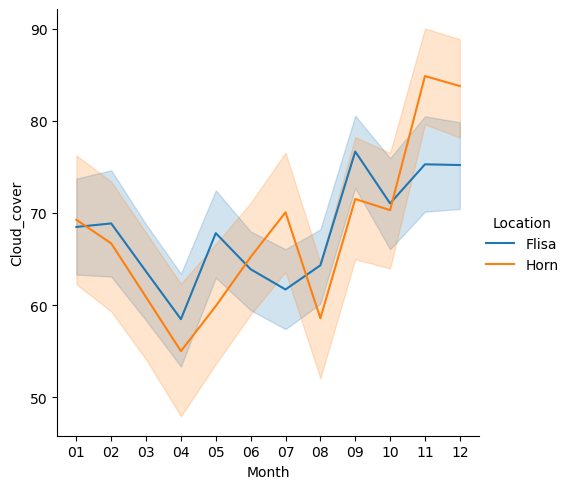

In [5]:
sns.relplot(x='Month', y='Cloud_cover', hue='Location', data=data_13, kind='line')

### Cloud cover distribution in the spring and summer

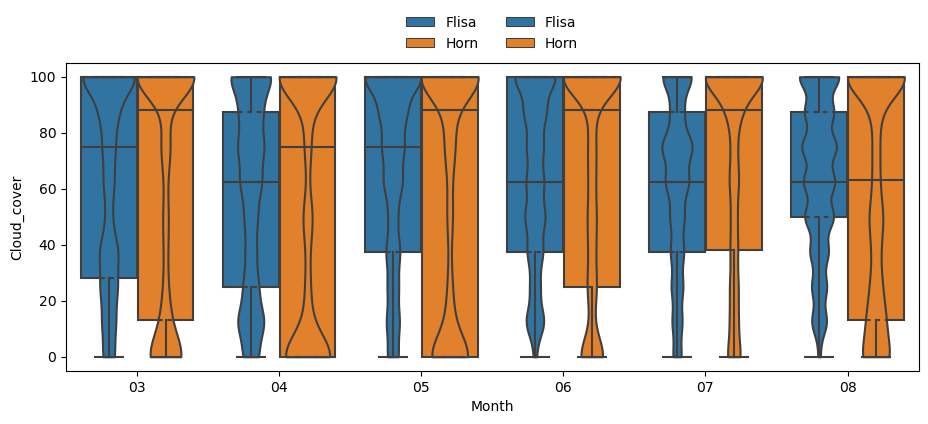

In [6]:
fig, ax = plt.subplots(1, figsize=(11,4))
sns.boxplot(ax=ax, x='Month', y='Cloud_cover', hue='Location', data=data_13_M2A)
sns.violinplot(ax=ax, x='Month', y='Cloud_cover', hue='Location',  bw=0.17, cut=0, split=False, inner='quart', data=data_13_M2A)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
)


Looking at this figure, we can see the cloud cover distribution in the spring and summer months. Here the middle line represents the median value. The median is lower for Flisa for all the spring and summer months, but from the distribution, we can see that Horn has more of an either/or type of weather, as in, it is either completely clouded, or completely clear. Flisa on the other hand is more likely to have partially clouded skies. It has a more uniform distribution with fewer very clear skies and fewer instances of complete cloud cover.

This difference in how the cloud cover values are distributed explains why the average cloud cover is lower for Horn but the median is lower for Flisa. Both the median and the average for both of the cities are well above 50% cloud cover though.

### Likelihood of having less than 50% (or 25%) cloud cover

<AxesSubplot: xlabel='Month', ylabel='Below 50% [%]'>

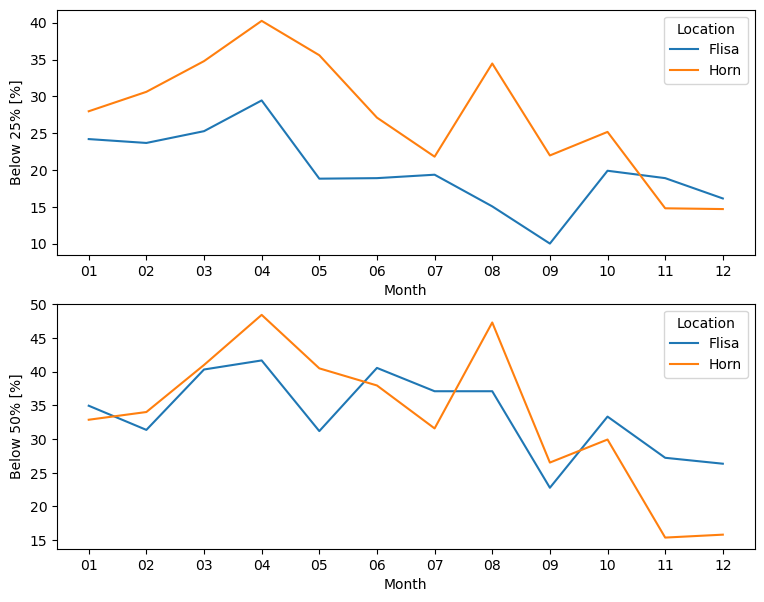

In [7]:
#================= Likelihood of up to 25 and 50% cloud cover at midday ===================
num_clear25_middays = data_13[data_13['Cloud_cover']<=25].groupby(['Location', 'Month'])['Day'].count()
num_clear50_middays = data_13[data_13['Cloud_cover']<=50].groupby(['Location', 'Month'])['Day'].count()
num_all_middays = data_13.groupby(['Location','Month'])['Day'].count()

num_clear25_middays.name='Under 25% middays'
num_clear50_middays.name='Under 50% middays'
num_all_middays.name='All days'

clear_middays = pd.concat([num_clear25_middays, num_clear50_middays, num_all_middays], axis="columns")
clear_middays['Below 25% [%]'] = clear_middays['Under 25% middays']/clear_middays['All days']*100
clear_middays['Below 50% [%]'] = clear_middays['Under 50% middays']/clear_middays['All days']*100
fig, ax = plt.subplots(2,1, figsize=(9,7))
sns.lineplot(ax=ax[0],x='Month', y='Below 25% [%]', hue='Location', data=clear_middays)
sns.lineplot(ax=ax[1],x='Month', y='Below 50% [%]', hue='Location', data=clear_middays)


To assess where the chances of getting reasonably clear skies are higher, I have looked at the likelihood of it being less than or equal to 50%, and less than or equal to 25% cloud cover. The figure above shows the probability of the cloud cover being 25% or less and 50% or less. Here again is Horn generally better and the difference becomes bigger when we look at the cloud cover below 25%. This fits with the differences in cloud cover distributions, as Horn has more "extreme" values. The chances of clear skies are the highest in Horn in April and August, when they reach almost a 50% chance of below 50% cover and around 35-40% chance of less than 25% cloud cover. In Flisa the chance of less than 50% is at best slightly above 40% and the chance of having less than 25% clouds is below 30%. While the difference between the two locations is not very large looking at up to 50% cloud cover, it is bigger when looking at up to 25%. Hence, if we are lucky enough to have below 50% cloud coverage in Horn, it is quite likely to actually be below 25%. 

Judging from this, it seems like Horn would provide a better chance of good conditions. 


### Cloud cover in Horn in the hours around noon

Since we have more finely sampled data for Horn, I have also checked what the chances of clear skies are during the time window 10:00-14:00. F


       Under 50%  All days  Below 50% around noon [%]
Month                                                
03            40       174                  22.988506
04            56       161                  34.782609
05            44       165                  26.666667
06            32       169                  18.934911
07            20       140                  14.285714
08            29       152                  19.078947


<AxesSubplot: xlabel='Month', ylabel='Below 50% around noon [%]'>

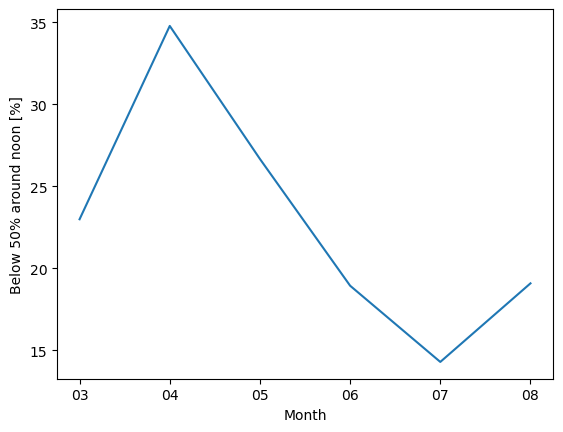

In [8]:
#================= Likelihood of less than 50% cloud cover at Vastervik 10:00-14:00 ===================
# Limiting analysis to the given time points
dataH = dataH[(dataH['Month']=='03') | (dataH['Month']=='04') | (dataH['Month']=='05') | (dataH['Month']=='06') | (dataH['Month']=='07') | (dataH['Month']=='08')]
dataH = dataH[(dataH['Time']=='10:00') | (dataH['Time']=='11:00') | (dataH['Time']=='12:00') | (dataH['Time']=='13:00') | (dataH['Time']=='14:00')]

num_clear50_mes_perday = dataH[dataH['Cloud_cover']<=50].groupby(['Month', 'Date'])['Date'].count()

num_all_mes_perday = dataH.groupby(['Month', 'Date'])['Date'].count()

num_clear50_mes_perday.name='Clear hours per day'
num_all_mes_perday.name='Tracked hours per day'


clear_days = pd.concat([num_clear50_mes_perday, num_all_mes_perday], axis="columns")
clear_days = clear_days.fillna(0)
clear_days.loc[clear_days['Clear hours per day']==clear_days['Tracked hours per day'], '<50%'] = True
clear_days.loc[clear_days['Clear hours per day']!=clear_days['Tracked hours per day'], '<50%'] = False

clear = clear_days[clear_days['<50%']==True].groupby(['Month'])['<50%'].count()
all_d = clear_days.groupby(['Month'])['<50%'].count()
clear.name='Under 50%'
all_d.name = 'All days'
#print(clear_days)
#print(clear)
#print(all_d)

df = pd.concat([clear, all_d], axis="columns")
df['Below 50% around noon [%]'] = df['Under 50%']/df['All days']*100
print(df)

sns.lineplot(x='Month', y='Below 50% around noon [%]', data=df)

The figure shows the likelihood of the cloud cover being less than or equal to 50% for the whole time span of 10:00 to 14:00 during the day. 

According to this, the best chances would be in April, with around 35% of the days having reasonably clear skies in the hours around noon.